# Coupling a dynamic MFA to an LCA

This notebook creates an "manure MFA" with a InflowDrivenStock (of the "storage" process) and couples one of its outputs to a static LCA.

In [1]:
import flodym as fd
import numpy as np
import bw2data as bd
# import bw2io as bi
import bw2calc as bc

18:28:00+0100 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


# MFA with flodym

In [2]:
dimension_definitions = [
    fd.DimensionDefinition(letter="t", name="time", dtype=int),
    fd.DimensionDefinition(letter="s", name="substance", dtype=str),
]

In [3]:
parameter_definitions = [
    fd.ParameterDefinition(name="manure", dim_letters=("t", "s")),
    fd.ParameterDefinition(name="fibre_shares", dim_letters=("s",)),
    fd.ParameterDefinition(name="substance_lifetimes", dim_letters=("s",)),
]

In [4]:
process_names = [
    "sysenv",
    "dewatering",
    "soil application",
    "storage",
]

In [5]:
flow_definitions = [
    fd.FlowDefinition(from_process_name="sysenv", to_process_name="dewatering", dim_letters=("t", "s")),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="storage", dim_letters=("t", "s")),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="soil application", dim_letters=("t", "s")),
    fd.FlowDefinition(from_process_name="storage", to_process_name="sysenv", dim_letters=("t", "s")),
    fd.FlowDefinition(from_process_name="soil application", to_process_name="sysenv", dim_letters=("t", "s")),
]

In [6]:
stock_definitions = [
    fd.StockDefinition(
        name="storage",
        process="storage",
        dim_letters=("t", "s"),  # Only substance dimension
        subclass=fd.InflowDrivenDSM,
        lifetime_model_class=fd.NormalLifetime,
    ),
]

In [7]:
mfa_definition = fd.MFADefinition(
    dimensions=dimension_definitions,
    parameters=parameter_definitions,
    processes=process_names,
    flows=flow_definitions,
    stocks=stock_definitions,
)

In [8]:
dimension_files = {
    "time": "data/dimension_time.csv",
    "substance": "data/dimension_substance.csv",
}

In [9]:
parameter_files = {
    "manure": "data/parameter_manure.csv",
    "fibre_shares": "data/parameter_fibre_shares.csv",
    "substance_lifetimes": "data/parameter_substance_lifetimes.csv",
}

In [10]:
class ManureMFA(fd.MFASystem):
    def compute(self):
        
        # Manure (sysenv => dewatering)
        self.flows["sysenv => dewatering"][...] = self.parameters["manure"]
        
        # Fibre (dewatering => soil application)
        self.flows["dewatering => soil application"][...] = (
            self.flows["sysenv => dewatering"] * self.parameters["fibre_shares"]
        )
        
        # Liquid (dewatering => storage)
        self.flows["dewatering => storage"][...] = (
            self.flows["sysenv => dewatering"] * (
                1 - self.parameters["fibre_shares"]
            )
        )
        
        # Soil application outflow (soil application => sysenv)
        self.flows["soil application => sysenv"][...] = (
            self.flows["dewatering => soil application"]
        )
        
        # Storage stock
        self.stocks["storage"].inflow[...] = (
            self.flows["dewatering => storage"]
        )
        self.stocks["storage"].lifetime_model.set_prms(
            mean=self.parameters["substance_lifetimes"],
            std=0.25*self.parameters["substance_lifetimes"],
        )
        self.stocks["storage"].compute()

        # Storage outflow (storage => sysenv)
        self.flows["storage => sysenv"][...] = (
            self.stocks["storage"].outflow
        )

In [11]:
mfa_example = ManureMFA.from_csv(
    definition=mfa_definition,
    dimension_files=dimension_files,
    parameter_files=parameter_files,
)

In [12]:
mfa_example.compute()

In [13]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

mfa_example.check_mass_balance()

INFO:root:Checking mass balance of ManureMFA object...
INFO:root:Success - Mass balance is consistent!


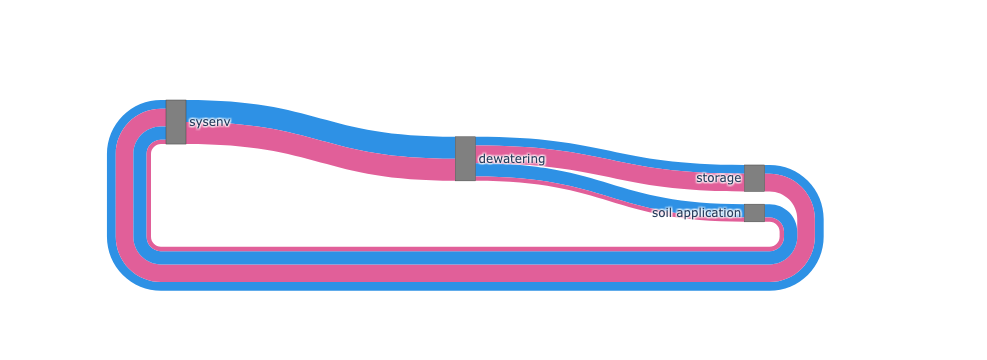

In [14]:
import flodym.export as fde
import plotly.colors as plc

fig = fde.PlotlySankeyPlotter(
    mfa=mfa_example,
    slice_dict={"t": 2025},
    exclude_processes=[], 
    flow_color_dict = {"default":("s", plc.qualitative.Dark24)}
).plot()
fig.show()

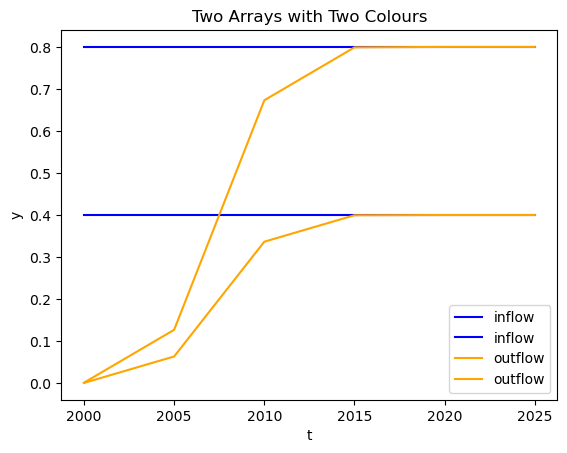

In [15]:
import matplotlib.pyplot as plt

# Generate two arrays
t = np.array([2000, 2005, 2010, 2015, 2020, 2025])
# y1 = np.sin(x)
# y2 = np.cos(x)

inflow = mfa_example.stocks["storage"].inflow.values
outflow = mfa_example.stocks["storage"].outflow.values

# Create the plot
plt.figure()
plt.plot(t, inflow, label='inflow', color='blue')
plt.plot(t, outflow, label='outflow', color='orange')
plt.legend()
plt.title("Two Arrays with Two Colours")
plt.xlabel("t")
plt.ylabel("y")
plt.show()

# LCA with Brightway

## Setup project and databases

Note: The code currently depends on the "ecoinvent-3.11-cutoff-bw25" project from DdS 2025. We only use this project to have easy access to ecoinvent on the DdS server. To use the script after the Autumn School, modify the code to import ecoinvent with your own license or a copy of ecoinvent on your computer.

In [23]:
project_name = "manure"

if project_name in bd.projects:
    bd.projects.delete_project(name=project_name, delete_dir=True)

if "ecoinvent-3.11-cutoff-bw25" in bd.projects:
    bd.projects.set_current("ecoinvent-3.11-cutoff-bw25")
    bd.projects.copy_project("manure", switch=True)
    if "lci-pass_cars" in bd.databases:
        del bd.databases["lci-pass_cars"]  # Redundant db from ecoinvent-3.11-cutoff-bw25
else:
    print("The project 'ecoinvent-3.11-cutoff-bw25' is not found.")

print("active project:", bd.projects.current)

active project: manure


In [24]:
db_name = "manure"

# To avoid mistakes, we recreate the manure_foreground database from scratch.
if db_name in bd.databases:
    del bd.databases[db_name]    
db = bd.Database(db_name)
db.register()
bd.databases

Databases dictionary with 3 object(s):
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-cutoff
	manure

## LCA setup

In [25]:
functional_unit_process = db.new_node(
    name='functional_unit_process',
    code='functional_unit_process',
    type=bd.labels.process_node_default,
)
functional_unit_process.save()

functional_unit_product = db.new_node(
    name='functional_unit',
    code='functional_unit',
    unit='kg',
    type=bd.labels.product_node_default,
)
functional_unit_product.save()

functional_unit_process.new_edge(
    amount=1,
    input=functional_unit_product,
    type=bd.labels.production_edge_default,    
).save()

In [26]:
activities_for_contribution_analysis = [
    {
        'name': 'storage methane',
        'unit': 'kg',
        # This is where we couple the MFA to the LCA
        'amount': mfa_example.stocks["storage"].stock[{'t': 2010, 's': "dry matter"}].values.item(),  # Single year
        'background_database_id': {
            'database': 'ecoinvent-3.11-biosphere',
            'name': 'Methane, non-fossil',
            'categories': ('air',),
            'code': 'da1157e2-7593-4dfd-80dd-a3449b37a4d8',
        }
    },
    {
        'name': 'dewatering electricity',
        'unit': 'kWh',
        'amount': 1,  # This could also be couple to an MFA amount but we don't do this yet.
        'background_database_id': {
            'database': 'ecoinvent-3.11-cutoff',
            'name': 'market for electricity, medium voltage',
            'code': '6bcbd7fc891c8b3bf0dd96027c1f9b0e',
        }
    },
]

In [27]:
for a in activities_for_contribution_analysis:
    product = db.new_node(
        name=a['name'],
        code=a['name'],
        type=bd.labels.product_node_default,
    )
    product.save()
    
    process = db.new_node(
        name=f'{a['name']}_process',
        code=f'{a['name']}_process',
        unit=a['unit'],
        type=bd.labels.process_node_default,
    )
    process.save()

    edge = process.new_edge(
        amount=1,
        input=product,
        type=bd.labels.production_edge_default,
    )
    edge.save()

    edge = functional_unit_process.new_edge(
        amount=1,
        input=product,
        type=bd.labels.consumption_edge_default,
    )
    edge.save()

    if a['background_database_id']['database'] == 'ecoinvent-3.11-biosphere':
        biosphere_flow = bd.get_node(
            database='ecoinvent-3.11-biosphere',
            code=a['background_database_id']['code'],
        )
       
        edge = process.new_edge(
            database='ecoinvent-3.11-biosphere',
            name=a['background_database_id']['name'],
            categories=a['background_database_id']['categories'],
            amount=a['amount'],
            input=biosphere_flow,
            type=bd.labels.biosphere_edge_default,
        )
        edge.save()
        
    elif a['background_database_id']['database'] == 'ecoinvent-3.11-cutoff':
        ecoinvent_product = bd.get_node(
            database='ecoinvent-3.11-cutoff',
            code=a['background_database_id']['code'],
        )
       
        edge = process.new_edge(
            database='ecoinvent-3.11-biosphere',
            name=a['background_database_id']['name'],
            amount=a['amount'],
            input=ecoinvent_product,
            type=bd.labels.consumption_edge_default,
        )
        edge.save()
    else:
        print('Ecoinvent database not found. Check database name.')  

## Performing LCA

In [28]:
functional_unit, data_objs, _ = bd.prepare_lca_inputs(
    {functional_unit_product: 1},
    method=('ecoinvent-3.11', 'CML v4.8 2016', 'climate change', 'global warming potential (GWP100)')
)

my_lca = bc.LCA(demand=functional_unit, data_objs=data_objs)
my_lca.lci()
my_lca.lcia()
my_lca.score

INFO:bw2calc:Initialized LCA object. Demand: {247413532889358336: 1}, data_objs: [<bw_processing.datapackage.Datapackage object at 0x7f3fe8d86180>, <bw_processing.datapackage.Datapackage object at 0x7f3fe8d87770>, <bw_processing.datapackage.Datapackage object at 0x7f3fe8d85dc0>, <bw_processing.datapackage.Datapackage object at 0x7f3fd49a8050>]


112.1027326525077

A contribution analysis is not added yet.

In [22]:
ecoinvent_el = get_mfa_value('sysenv => dewatering', 'dry matter')
storage_dm = get_mfa_value('dewatering => storage', 'dry matter')

NameError: name 'get_mfa_value' is not defined

In [ ]:
# nodes
manure_management = db.new_node(
    name='manure management',
    unit='ton',
    type=bd.labels.product_node_default,
)
manure_management.save()

manure_management_process = db.new_node(
    name='manure management process',
    location='DK',
    type=bd.labels.process_node_default,
)
manure_management_process.save()

electricity = db.new_node(
    name='electricity',
    unit='kWh',
    location='DK',
    type=bd.labels.product_node_default,
)
electricity.save()

dewatering_electricity = db.new_node(
    name='dewatering electricity',
    location='DK',
    type=bd.labels.process_node_default,
)
dewatering_electricity.save()

methane = db.new_node(
    name='methane',
    unit='kg',
    type=bd.labels.product_node_default,
)
methane.save()

storage_methane = db.new_node(
    name='storage methane',
    location='DK',
    type=bd.labels.process_node_default,
)
storage_methane.save()

In [ ]:
bd.databases

In [ ]:
#ei = bd.Database('ecoinvent-3.11-cutoff')
ei_electricity = bd.get_node(
    database='ecoinvent-3.11-cutoff',
    name='market for electricity, medium voltage',
    location='DK',
)

bs_methane = bd.get_node(
    database='ecoinvent-3.11-biosphere',
    name='Methane, non-fossil',
    categories=('air',)        
)

In [ ]:
ei_electricity

In [ ]:
manure_management_process.new_edge(
    amount=1,
    input=manure_management,
    type=bd.labels.production_edge_default,
).save()

manure_management_process.new_edge(
    amount=1,
    input=electricity,
    type=bd.labels.consumption_edge_default,
).save()

manure_management_process.new_edge(
    amount=1,
    input=methane,
    type=bd.labels.consumption_edge_default,
).save()

dewatering_electricity.new_edge(
    amount=1,
    input=electricity,
    type=bd.labels.production_edge_default
).save()

dewatering_electricity.new_edge(
    amount=1000,
    input=ei_electricity,
    type=bd.labels.consumption_edge_default,
).save()

storage_methane.new_edge(
    amount=1,
    input=methane,
    type=bd.labels.production_edge_default,
).save()

storage_methane.new_edge(
    amount=1,
    input=bs_methane,
    type=bd.labels.biosphere_edge_default,
).save()

In [ ]:
my_method = bd.Method(
    ('ecoinvent-3.11', 
     'CML v4.8 2016', 
     'climate change', 
     'global warming potential (GWP100)')
)
my_method.name